<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

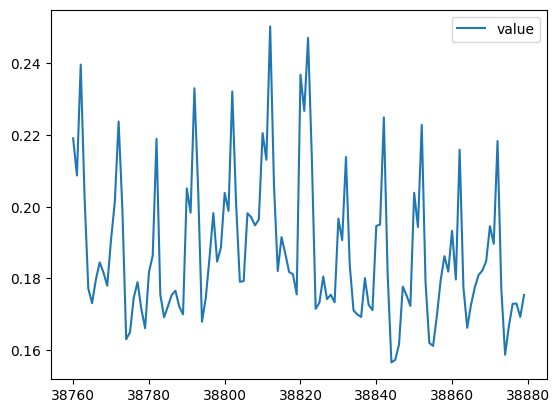

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 10
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
       
        
        self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_plus = nn.Linear(2880,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        
   
            
        new_input = torch.cat([seasonal_init,trend_init],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_618367/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [14]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [15]:
torch.manual_seed(42)

In [16]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 13.234480497868436 %
smape 11.56152889960342 %
smape 10.738187291555935 %
smape 10.302272533115588 %
smape 10.032868021064335 %
smape 9.84058672355281 %
smape 9.684328689561253 %
smape 9.553740043302028 %
smape 9.441170444962573 %
smape 9.343349675686039 %
smape 9.259419947078355 %
smape 9.190166973405415 %
smape 9.136325553146719 %
smape 9.091903505879536 %
smape 9.051064586168842 %
smape 9.01541665414272 %
smape 8.983252645846 %
smape 8.95074359070488 %
smape 8.924886999510186 %
smape 8.90532171604229 %
smape 8.883713051153903 %
smape 8.870192801046093 %
smape 8.856248436876905 %
smape 8.83888725343852 %
smape 8.829600193608574 %
smape 8.817285846984177 %
smape 8.806215810061198 %
smape 8.798643382407768 %
smape 8.783457777217816 %
smape 8.772712886682031 %
smape 8.765965777269582 %
smape 8.759402639684621 %
smape 8.749491698299234 %
smape 8.742705651978303 %
smape 8.736760017206096 %
smape 8.730586157643307 %
smape 8.72061456504621 %
smape 8.705674842087149 %
smape 8.704257329

In [17]:
torch.manual_seed(42)

In [18]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [19]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.4116512570499253 %
SMAPE 11.32219894323498 %
SMAPE 1.2758684571890626 %
SMAPE 0.1246100769280929 %
SMAPE 0.39062539915539674 %
SMAPE 0.920028259519313 %
SMAPE 0.4777849337410771 %
SMAPE 0.4673354548586985 %
SMAPE 0.9502582571858511 %
SMAPE 0.8855149637220165 %
SMAPE 2.095607778595877 %
SMAPE 0.09022827253556898 %
SMAPE 0.23895476533652982 %
SMAPE 0.5633001437217899 %
SMAPE 2.147730608272468 %
SMAPE 0.45851661793858517 %
SMAPE 1.0675731045739667 %
SMAPE 3.362794272317842 %
SMAPE 0.6153446679782064 %
SMAPE 0.8248377874979269 %
SMAPE 4.780327211730764 %
SMAPE 0.09650942062307877 %
SMAPE 5.309002621183026 %
SMAPE 0.710206510538228 %
SMAPE 2.7900814453182647 %
SMAPE 4.470512195752235 %
SMAPE 0.534913115647214 %
SMAPE 0.5805078919137259 %
SMAPE 0.6186577948037666 %
SMAPE 0.24613543347072664 %
SMAPE 0.7048713851932007 %
SMAPE 0.47934797275229357 %
SMAPE 0.04782251640017421 %
SMAPE 0.06724692795069132 %
SMAPE 1.4475968177894174 %
SMAPE 0.27616394028018476 %
SMAPE 0.7415944222757389 %
S

SMAPE 2.8667694365958596 %
SMAPE 0.3670652965597583 %
SMAPE 0.8666660017624963 %
SMAPE 3.096835559219471 %
SMAPE 0.06324788284814531 %
SMAPE 1.3419313337835774 %
SMAPE 0.49406886890210444 %
SMAPE 0.4001961741996638 %
SMAPE 0.5808946546430889 %
SMAPE 1.3593968375307668 %
SMAPE 2.5745627806463744 %
SMAPE 1.3010688223057514 %
SMAPE 22.653900027275085 %
SMAPE 4.731974645937953 %
SMAPE 0.10956177613206819 %
SMAPE 1.3546679837727424 %
SMAPE 0.44969830206537154 %
SMAPE 0.6448902904885472 %
SMAPE 1.756028074581991 %
SMAPE 0.480728723872744 %
SMAPE 0.13344214864719106 %
SMAPE 0.27426940468012617 %
SMAPE 0.22942357203561414 %
SMAPE 0.8354019021471686 %
SMAPE 0.25726755256346223 %
SMAPE 2.1480762509745546 %
SMAPE 1.8433734702903166 %
SMAPE 0.22642009887204037 %
SMAPE 0.26228207787062274 %
SMAPE 2.2800701879532426 %
SMAPE 4.0643095017644555 %
SMAPE 0.03654940200431156 %
SMAPE 1.0754473463821341 %
SMAPE 0.7725560967412264 %
SMAPE 1.1139291605259132 %
SMAPE 1.2659674377391639 %
SMAPE 0.1136361395024

SMAPE 0.03112906753040079 %
SMAPE 1.5936107659217669 %
SMAPE 1.15626474810324 %
SMAPE 0.8977273557757144 %
SMAPE 1.731834934096696 %
SMAPE 2.213971823332031 %
SMAPE 0.1351719085921559 %
SMAPE 0.06276314458682464 %
SMAPE 3.571635700242041 %
SMAPE 0.08110094019866665 %
SMAPE 0.35208469563980316 %
SMAPE 0.03210421089210058 %
SMAPE 1.1540997607517056 %
SMAPE 1.5297925514887538 %
SMAPE 1.6004429196473209 %
SMAPE 1.8205183855607174 %
SMAPE 0.16113645950116506 %
SMAPE 0.614123102456233 %
SMAPE 0.6282695621841867 %
SMAPE 0.2601077856870688 %
SMAPE 0.09640974769263266 %
SMAPE 1.4276841429173146 %
SMAPE 0.921997454065604 %
SMAPE 0.11054789110494312 %
SMAPE 6.818679294661706 %
SMAPE 0.5039661328846705 %
SMAPE 0.07386930467100683 %
SMAPE 1.3448542324895243 %
SMAPE 1.720177541354133 %
SMAPE 0.05688494420860479 %
SMAPE 0.42504313764857216 %
SMAPE 0.2371825113095838 %
SMAPE 0.688622995505284 %
SMAPE 0.6443357669431862 %
SMAPE 0.03215561007527867 %
SMAPE 0.3618496872638275 %
SMAPE 1.0602827822167455 %

SMAPE 0.6128877024611938 %
SMAPE 0.3004922043401166 %
SMAPE 0.32626016786525724 %
SMAPE 0.659063723395775 %
SMAPE 0.4145757201968081 %
SMAPE 0.6904301178201422 %
SMAPE 0.11323131669632856 %
SMAPE 0.05112316946997452 %
SMAPE 1.3682861018642143 %
SMAPE 1.0589182781814088 %
SMAPE 2.365303714255788 %
SMAPE 0.23858383790093285 %
SMAPE 0.5441052408168616 %
SMAPE 0.08375898454664821 %
SMAPE 1.2729787589469197 %
SMAPE 0.14004046562195072 %
SMAPE 0.15532795553644974 %
SMAPE 0.13638616640582768 %
SMAPE 0.17111365397158806 %
SMAPE 0.8459655714605105 %
SMAPE 1.2100718016954488 %
SMAPE 0.19925453313044272 %
SMAPE 0.9470799858409009 %
SMAPE 0.8727356455119661 %
SMAPE 0.40121531087766016 %
SMAPE 0.09262343505803017 %
SMAPE 0.2582704886626743 %
SMAPE 0.447345631731423 %
SMAPE 0.3840876140963019 %
SMAPE 2.264355709202391 %
SMAPE 0.15868515730835497 %
SMAPE 0.7463188418059872 %
SMAPE 0.18929042619924985 %
SMAPE 0.373376604563191 %
SMAPE 0.12654189930526627 %
SMAPE 0.767594089765339 %
SMAPE 0.23141613662

SMAPE 0.5506478716347374 %
SMAPE 0.5033707308862176 %
SMAPE 0.29671269646041765 %
SMAPE 1.4874881034966165 %
SMAPE 0.5007435725542564 %
SMAPE 0.31822177746772695 %
SMAPE 0.13726570667586202 %
SMAPE 0.3292693561077158 %
SMAPE 0.36167587541899593 %
SMAPE 0.05889753569408639 %
SMAPE 0.32372147011528796 %
SMAPE 1.0232404229791427 %
SMAPE 2.7494037439601016 %
SMAPE 0.2802572328180304 %
SMAPE 0.30250477225490613 %
SMAPE 0.08480259073257912 %
SMAPE 0.05763571570753356 %
SMAPE 0.3297863705265627 %
SMAPE 0.894881765836317 %
SMAPE 0.5440872303618107 %
SMAPE 0.6793955419453823 %
SMAPE 1.1773905158370326 %
SMAPE 1.3861300108728756 %
SMAPE 2.123025619848704 %
SMAPE 0.4936600949374679 %
SMAPE 0.6722029127088263 %
SMAPE 0.8888406375494923 %
SMAPE 0.029330059083349624 %
SMAPE 1.181277662027128 %
SMAPE 0.42411654002711435 %
SMAPE 0.3814026496702354 %
SMAPE 0.9384748405209394 %
SMAPE 0.05539530819442007 %
SMAPE 0.5081371865335313 %
SMAPE 0.10480446703172676 %
SMAPE 0.8125008017832441 %
SMAPE 0.233167467

SMAPE 0.07970102371388066 %
SMAPE 0.6688937849676222 %
SMAPE 0.16901964693715854 %
SMAPE 0.32967260371333396 %
SMAPE 0.1441196724990732 %
SMAPE 0.29124409032738185 %
SMAPE 0.667757484881804 %
SMAPE 0.2327402346152212 %
SMAPE 1.1380951744067715 %
SMAPE 0.47205704320094805 %
SMAPE 0.5565863333249581 %
SMAPE 0.3333391075129839 %
SMAPE 0.16047171771640478 %
SMAPE 0.34210443016877434 %
SMAPE 0.1872246821670842 %
SMAPE 0.6858489789506166 %
SMAPE 2.250292583625651 %
SMAPE 0.7636963698187174 %
SMAPE 0.1878049969350286 %
SMAPE 0.26139419281139453 %
SMAPE 0.9176013842250086 %
SMAPE 0.15429847914310812 %
SMAPE 0.8218264954348343 %
SMAPE 0.264593218446862 %
SMAPE 1.8161475265806075 %
SMAPE 0.5342631241812796 %
SMAPE 0.18291482343920507 %
SMAPE 2.202528789811595 %
SMAPE 0.24280838340973784 %
SMAPE 0.09950574157119264 %
SMAPE 0.45701638901778097 %
SMAPE 0.058414496100454016 %
SMAPE 0.02640051375749408 %
SMAPE 0.27521498385794985 %
SMAPE 0.05295831648254534 %
SMAPE 0.4601948993918086 %
SMAPE 0.421904

SMAPE 0.8467492244035384 %
SMAPE 0.967000549225304 %
SMAPE 0.6801061620190012 %
SMAPE 0.7864215262861762 %
SMAPE 0.045810800657619666 %
SMAPE 0.1837613404215972 %
SMAPE 0.5108035044809185 %
SMAPE 0.19030737229331862 %
SMAPE 0.868894879645154 %
SMAPE 0.8140886253859207 %
SMAPE 0.7987693745290017 %
SMAPE 1.1498249714168196 %
SMAPE 0.0721351798674732 %
SMAPE 0.5959918107400881 %
SMAPE 0.1350272133568069 %
SMAPE 0.051584846991659106 %
SMAPE 0.9192341609450523 %
SMAPE 2.1859678156392874 %
SMAPE 0.4777643182897009 %
SMAPE 0.21615929395602507 %
SMAPE 1.2870624051438426 %
SMAPE 0.5502913985101259 %
SMAPE 0.9136529387160409 %
SMAPE 0.6100598832927062 %
SMAPE 0.23388591420030028 %
SMAPE 13.29393249299028 %
SMAPE 7.097549052268732 %
SMAPE 2.1541181599786796 %
SMAPE 2.1953027125055087 %
SMAPE 0.2719733212979918 %
SMAPE 0.29606464948665234 %
SMAPE 0.7019704838767211 %
SMAPE 0.2352638055933767 %
SMAPE 0.036411452351785556 %
SMAPE 1.4433061204945261 %
SMAPE 2.594445161805197 %
SMAPE 0.296935260990721

SMAPE 0.8544427146159707 %
SMAPE 1.0264408844623176 %
SMAPE 0.327916687306697 %
SMAPE 1.2308493356322288 %
SMAPE 0.2883991249718747 %
SMAPE 0.08517103158374084 %
SMAPE 0.06317094178484695 %
SMAPE 1.3616256650311698 %
SMAPE 0.48612065904580953 %
SMAPE 6.177165085129673 %
SMAPE 3.8060299322587525 %
SMAPE 6.819239758406185 %
SMAPE 1.2883393897045607 %
SMAPE 0.1350936178300799 %
SMAPE 0.18872150011017652 %
SMAPE 0.6420859388090321 %
SMAPE 0.2348056129734459 %
SMAPE 0.8068496666130613 %
SMAPE 0.12694836549644606 %
SMAPE 0.04479308029931417 %
SMAPE 0.3903461676718507 %
SMAPE 0.9009470505899344 %
SMAPE 0.5698328968874193 %
SMAPE 1.034090220888345 %
SMAPE 0.18158471616391125 %
SMAPE 1.1703758329185803 %
SMAPE 0.8083465049785444 %
SMAPE 0.5931581525173897 %
SMAPE 0.23416057665963308 %
SMAPE 0.14840954375904403 %
SMAPE 2.6014964664900617 %
SMAPE 0.2000603736487392 %
SMAPE 1.4827545042517158 %
SMAPE 0.057812892941456084 %
SMAPE 2.2577828894945924 %
SMAPE 0.9706552664902119 %
SMAPE 0.0942052726873

SMAPE 0.07300055003361194 %
SMAPE 0.03869822287433067 %
SMAPE 1.0118743689872645 %
SMAPE 0.16815989860333502 %
SMAPE 0.12127077602781355 %
SMAPE 0.16667627818088704 %
SMAPE 0.11555377176989622 %
SMAPE 0.1444426600432962 %
SMAPE 7.8543637417024 %
SMAPE 1.8878163086537825 %
SMAPE 0.28318043541003135 %
SMAPE 0.453790490022584 %
SMAPE 1.3783130261526821 %
SMAPE 1.4082564558843842 %
SMAPE 1.3514294891228928 %
SMAPE 3.2958335393759626 %
SMAPE 0.5784809234569366 %
SMAPE 0.9863193969616759 %
SMAPE 2.951656598397676 %
SMAPE 2.3793903822843276 %
SMAPE 1.405485554477309 %
SMAPE 0.7645771094776137 %
SMAPE 0.8970993283101051 %
SMAPE 0.04208645208609596 %
SMAPE 2.453207305039541 %
SMAPE 1.9191499231674243 %
SMAPE 0.7214734688641329 %
SMAPE 1.4289037048438331 %
SMAPE 0.08282471577524575 %
SMAPE 2.4425128396735545 %
SMAPE 1.6789987071533687 %
SMAPE 0.04317201017397565 %
SMAPE 0.8447215391570353 %
SMAPE 0.4131869497932712 %
SMAPE 0.5032897473201956 %
SMAPE 1.2181592774068122 %
SMAPE 0.1273408519455188 

SMAPE 0.3359923402322238 %
SMAPE 0.09525091369005168 %
SMAPE 0.3946327608318824 %
SMAPE 0.7327245873075299 %
SMAPE 0.10352259881256032 %
SMAPE 1.873980574052439 %
SMAPE 0.18517761518842235 %
SMAPE 0.4204053725420636 %
SMAPE 1.4362154841510346 %
SMAPE 0.12208487514226363 %
SMAPE 1.4306593740693643 %
SMAPE 0.27329593120884965 %
SMAPE 0.06968683523200525 %
SMAPE 0.12123077843671126 %
SMAPE 0.1529365716905886 %
SMAPE 0.08197535654335297 %
SMAPE 1.0513312555090124 %
SMAPE 1.101057495961868 %
SMAPE 0.7508559610669181 %
SMAPE 0.7167777047111485 %
SMAPE 2.31112176003262 %
SMAPE 0.22024927302481956 %
SMAPE 0.4259561536816819 %
SMAPE 1.215865065711796 %
SMAPE 0.0824933824078471 %
SMAPE 0.034297754216822796 %
SMAPE 1.214996073503471 %
SMAPE 1.6063502421857265 %
SMAPE 0.06745106518337707 %
SMAPE 0.3086867053984861 %
SMAPE 0.5141279363961075 %
SMAPE 0.40019083849074377 %
SMAPE 0.07203679558733711 %
SMAPE 0.09635493370387849 %
SMAPE 0.10382928152750993 %
SMAPE 0.041144718741406905 %
SMAPE 0.06827282

SMAPE 0.5418405452300448 %
SMAPE 5.333234779020131 %
SMAPE 0.9491783785342705 %
SMAPE 0.2181697647627061 %
SMAPE 0.23459006941584448 %
SMAPE 0.6182064739855377 %
SMAPE 0.35628769545292016 %
SMAPE 0.1771706237050239 %
SMAPE 5.08572530024685 %
SMAPE 0.5802906354224433 %
SMAPE 0.5218817181857958 %
SMAPE 0.3712252194513894 %
SMAPE 0.06305591844203207 %
SMAPE 0.8341228118624713 %
SMAPE 2.0737614393283366 %
SMAPE 0.21214832759915225 %
SMAPE 0.2896180035368161 %
SMAPE 1.9015380252922112 %
SMAPE 0.756982479853832 %
SMAPE 0.05774893581656215 %
SMAPE 1.2380633543871227 %
SMAPE 0.8230571629530914 %
SMAPE 0.2935745000402221 %
SMAPE 2.9386753361341107 %
SMAPE 0.30666710509103723 %
SMAPE 0.3060150212886583 %
SMAPE 1.3631892386483742 %
SMAPE 0.011925729500944726 %
SMAPE 0.9572676730945204 %
SMAPE 0.10832538793511048 %
SMAPE 0.7856655635864627 %
SMAPE 1.1681588783503685 %
SMAPE 0.3322320595916608 %
SMAPE 0.308036765100951 %
SMAPE 0.03150554999197652 %
SMAPE 0.6289049869549217 %
SMAPE 1.367949238963774

SMAPE 0.7617982997071522 %
SMAPE 1.2006752036858188 %
SMAPE 3.589950173030956 %
SMAPE 1.9775199635164429 %
SMAPE 0.7720782973437963 %
SMAPE 0.4701751681805036 %
SMAPE 0.5903954641235032 %
SMAPE 0.42192295724998985 %
SMAPE 0.36742720589336386 %
SMAPE 2.1645403557340614 %
SMAPE 0.40252965060471985 %
SMAPE 0.5978782743459305 %
SMAPE 0.21117834898200272 %
SMAPE 3.1405516290117252 %
SMAPE 0.12199575164777343 %
SMAPE 1.5778743849441526 %
SMAPE 0.09422697359923404 %
SMAPE 1.9052756224173208 %
SMAPE 1.067852107235467 %
SMAPE 2.163781954030128 %
SMAPE 0.7873444051660954 %
SMAPE 0.6196173080516019 %
SMAPE 0.13009364769450116 %
SMAPE 1.3112008139146383 %
SMAPE 0.19547214659837664 %
SMAPE 1.4094036057358608 %
SMAPE 0.09014237180781492 %
SMAPE 0.574477822665358 %
SMAPE 0.7065671630666657 %
SMAPE 5.101374493293406 %
SMAPE 0.13138633593484883 %
SMAPE 0.07130631534892018 %
SMAPE 0.6124582553366054 %
SMAPE 0.25154678137369046 %
SMAPE 0.6315639840750009 %
SMAPE 2.13105078801118 %
SMAPE 3.305378898821800

SMAPE 0.112057148806457 %
SMAPE 1.1487116641210378 %
SMAPE 0.4881739812472006 %
SMAPE 0.08959365166083444 %
SMAPE 0.279077338087518 %
SMAPE 0.2975953282186765 %
SMAPE 0.25289685648567684 %
SMAPE 0.13877027017997534 %
SMAPE 0.3983126301479842 %
SMAPE 0.35608690945696253 %
SMAPE 0.1365248161528143 %
SMAPE 0.1333804902852762 %
SMAPE 0.4643876934078434 %
SMAPE 0.027567718658247035 %
SMAPE 0.021091451445414577 %
SMAPE 3.766368512820918 %
SMAPE 0.1738647004737004 %
SMAPE 1.3862175249932989 %
SMAPE 0.6973012631954134 %
SMAPE 1.5989227813042814 %
SMAPE 0.571623271941121 %
SMAPE 1.0629949207868776 %
SMAPE 0.13855548778519733 %
SMAPE 0.06346122781178565 %
SMAPE 0.69017912539789 %
SMAPE 0.7644886100715667 %
SMAPE 0.29929219341465796 %
SMAPE 0.47721734174547237 %
SMAPE 0.02478283396658298 %
SMAPE 0.38658315219981887 %
SMAPE 0.2212494897285069 %
SMAPE 0.348031981728127 %
SMAPE 0.8924003048523446 %
SMAPE 1.3172322979808087 %
SMAPE 1.3518734896315436 %
SMAPE 0.0933546022461087 %
SMAPE 0.4239617203638

SMAPE 0.606119080886856 %
SMAPE 0.13034407081335075 %
SMAPE 0.35181506283333874 %
SMAPE 1.8171817878646837 %
SMAPE 0.48427458644732724 %
SMAPE 0.258788468531975 %
SMAPE 1.3872198716589992 %
SMAPE 0.36314363469787736 %
SMAPE 0.06621257223423527 %
SMAPE 0.33945485562571776 %
SMAPE 0.20194898671593361 %
SMAPE 0.10718398322228495 %
SMAPE 0.09707710819736803 %
SMAPE 0.6996358264950686 %
SMAPE 0.08620735205141017 %
SMAPE 0.5397420102926844 %
SMAPE 0.10400041931870874 %
SMAPE 0.133760244499058 %
SMAPE 0.49989729605658795 %
SMAPE 0.04190213218930694 %
SMAPE 1.1349941010921611 %
SMAPE 0.13495362213893713 %
SMAPE 0.11933314832913311 %
SMAPE 0.22667611486758688 %
SMAPE 0.3388048140950559 %
SMAPE 0.10134685227990305 %
SMAPE 0.10941841588817171 %
SMAPE 0.6966566971750581 %
SMAPE 0.9799768832217525 %
SMAPE 0.5297480205772445 %
SMAPE 0.4659797319691279 %
SMAPE 0.3464981672027534 %
SMAPE 0.5156825483500143 %
SMAPE 0.4535017856132981 %
SMAPE 0.8920776787135765 %
SMAPE 0.3914579047504958 %
SMAPE 0.07268

SMAPE 0.19842892841006685 %
SMAPE 0.39240294571391127 %
SMAPE 0.1592932355054586 %
SMAPE 0.24207374892148437 %
SMAPE 0.8354572497155458 %
SMAPE 0.06567395141999555 %
SMAPE 0.05580640896255318 %
SMAPE 0.0388367284151343 %
SMAPE 0.4976252431456487 %
SMAPE 0.5083438037781889 %
SMAPE 0.2098530171861057 %
SMAPE 0.15797097214908717 %
SMAPE 0.4895625742074116 %
SMAPE 0.406877650959359 %
SMAPE 0.1023056464664478 %
SMAPE 0.810670365801343 %
SMAPE 1.3628905427867721 %
SMAPE 0.16982691227747182 %
SMAPE 0.8865022838526783 %
SMAPE 1.4637606999640411 %
SMAPE 0.18871664105154196 %
SMAPE 0.31462413258498145 %
SMAPE 0.4202753340778144 %
SMAPE 0.19163871011460287 %
SMAPE 0.4278415549003966 %
SMAPE 1.4165406903427424 %
SMAPE 0.6371227658430598 %
SMAPE 2.346855231517111 %
SMAPE 0.2939057560670335 %
SMAPE 0.23438460610168474 %
SMAPE 0.5903199810963997 %
SMAPE 0.6994550282615819 %
SMAPE 1.1372135086166963 %
SMAPE 2.5091051290219184 %
SMAPE 1.0239090564191429 %
SMAPE 0.27473536264187715 %
SMAPE 0.98153203484

SMAPE 1.311101546003556 %
SMAPE 4.119702478770705 %
SMAPE 0.21241142218423192 %
SMAPE 0.33784256044600625 %
SMAPE 0.6951649238847892 %
SMAPE 0.8698298795375194 %
SMAPE 2.1448176980884455 %
SMAPE 0.10474853058440203 %
SMAPE 0.7772178693116985 %
SMAPE 0.5084587582771292 %
SMAPE 0.8627531952961364 %
SMAPE 0.24418894111022382 %
SMAPE 0.9624215320573057 %
SMAPE 0.5970141176572952 %
SMAPE 0.07232964481954696 %
SMAPE 0.05060933339973417 %
SMAPE 0.18811455843388103 %
SMAPE 0.47091749052952986 %
SMAPE 2.3065322910115356 %
SMAPE 0.536059698387362 %
SMAPE 1.1738979549518263 %
SMAPE 0.06916179877543982 %
SMAPE 2.1420222473134345 %
SMAPE 1.9635639876214555 %
SMAPE 0.6167869646089912 %
SMAPE 0.10556551128752288 %
SMAPE 1.1894688606735144 %
SMAPE 8.162664812809453 %
SMAPE 0.2849981408444364 %
SMAPE 1.3291086869976425 %
SMAPE 14.423107240349054 %
SMAPE 4.922280746475735 %
SMAPE 1.210168322488471 %
SMAPE 13.732297494600063 %
SMAPE 1.3206698211361072 %
SMAPE 1.9008097808400637 %
SMAPE 0.4514634696570283

SMAPE 0.4285232171107509 %
SMAPE 0.09324939078942407 %
SMAPE 0.03618077497259975 %
SMAPE 0.7509307361074207 %
SMAPE 0.15311297748212382 %
SMAPE 0.6157654729140631 %
SMAPE 0.26651664180008083 %
SMAPE 0.6061998661598409 %
SMAPE 1.769107753178105 %
SMAPE 0.4968649025634022 %
SMAPE 0.29619474216701747 %
SMAPE 0.5970179043216888 %
SMAPE 0.785208521374443 %
SMAPE 1.2578989833527885 %
SMAPE 0.16745455936757025 %
SMAPE 1.261119763614488 %
SMAPE 0.2361931899590672 %
SMAPE 0.5062492774220573 %
SMAPE 10.547895204275846 %
SMAPE 3.683436708779482 %
SMAPE 0.28085642908695263 %
SMAPE 0.16237033401012013 %
SMAPE 0.9970116792428598 %
SMAPE 0.09664990787973693 %
SMAPE 1.2876706838615064 %
SMAPE 1.0376957064747785 %
SMAPE 0.5826553182669159 %
SMAPE 0.39976196420138876 %
SMAPE 0.05852909122859274 %
SMAPE 0.039207397396239685 %
SMAPE 0.493214476313824 %
SMAPE 0.15492349394020266 %
SMAPE 0.5008178512052837 %
SMAPE 0.16281947876228742 %
SMAPE 0.015227106813313187 %
SMAPE 0.16067397133883787 %
SMAPE 0.7896069

SMAPE 0.8699266394144161 %
SMAPE 0.17681135057182473 %
SMAPE 0.03912109445036549 %
SMAPE 0.037873876857027255 %
SMAPE 0.20038123219455883 %
SMAPE 0.03940744882584113 %
SMAPE 2.746910458596176 %
SMAPE 0.5064970681487466 %
SMAPE 1.095456186843876 %
SMAPE 0.6054045942504445 %
SMAPE 1.69221853054583 %
SMAPE 1.468744861369487 %
SMAPE 0.3075240059861244 %
SMAPE 0.09381328021845547 %
SMAPE 0.6938426229025936 %
SMAPE 0.22810272527408415 %
SMAPE 0.6925844328216044 %
SMAPE 1.1724412541843776 %
SMAPE 1.2831417371526186 %
SMAPE 0.19942204862752533 %
SMAPE 2.4920990351602086 %
SMAPE 1.035909904121354 %
SMAPE 0.2543603924832496 %
SMAPE 0.590154514216465 %
SMAPE 0.3394837099369852 %
SMAPE 0.0719997438336577 %
SMAPE 2.455249253544025 %
SMAPE 0.1548139375554456 %
SMAPE 0.10109889303248565 %
SMAPE 1.0832853496831376 %
SMAPE 0.519156751999617 %
SMAPE 0.7620091975277319 %
SMAPE 0.42546836918870673 %
SMAPE 0.7529286763838172 %
SMAPE 0.2411326592698515 %
SMAPE 1.7466624298285751 %
SMAPE 0.212857842237554 %


SMAPE 0.10014720948083777 %
SMAPE 0.10858060031750938 %
SMAPE 2.96600005957589 %
SMAPE 0.7075662628171813 %
SMAPE 1.3687683857788215 %
SMAPE 1.193353455979377 %
SMAPE 0.35609220559854293 %
SMAPE 1.6009252118601582 %
SMAPE 0.7601177655833453 %
SMAPE 1.909289234330345 %
SMAPE 0.4689747887805424 %
SMAPE 0.24850870185855453 %
SMAPE 2.3040413234116386 %
SMAPE 1.0619776831099443 %
SMAPE 1.433496687456227 %
SMAPE 0.24336973151719124 %
SMAPE 0.2808732069170219 %
SMAPE 0.22507916432005004 %
SMAPE 0.2980206298620942 %
SMAPE 2.889851874439046 %
SMAPE 1.3339567987968621 %
SMAPE 1.210040875368577 %
SMAPE 1.7422122975003733 %
SMAPE 1.544875812236569 %
SMAPE 0.35037502343038796 %
SMAPE 1.0939178685423485 %
SMAPE 0.04027866867636476 %
SMAPE 3.4715917694393283 %
SMAPE 1.1289911365220178 %
SMAPE 2.2334742401799303 %
SMAPE 0.8863270491037838 %
SMAPE 0.6045741164198262 %
SMAPE 3.350763228503638 %
SMAPE 0.7784943748506521 %
SMAPE 1.317126510279195 %
SMAPE 0.510369830976515 %
SMAPE 0.41834148574889696 %
SMA

SMAPE 0.6146610713067275 %
SMAPE 0.7490224327293618 %
SMAPE 0.37394604713017543 %
SMAPE 0.03351749721541353 %
SMAPE 0.3824310032255198 %
SMAPE 0.15626372671363242 %
SMAPE 1.1455466870465898 %
SMAPE 0.11642443129267122 %
SMAPE 0.3309449153816786 %
SMAPE 1.4479445104734623 %
SMAPE 0.23580072648826444 %
SMAPE 3.4181841755926143 %
SMAPE 0.11579592997532018 %
SMAPE 0.36174152117575886 %
SMAPE 0.5397964369965393 %
SMAPE 0.17049443931145447 %
SMAPE 0.13368382834232762 %
SMAPE 0.3633491365158079 %
SMAPE 0.47062864424901824 %
SMAPE 2.0206272479445033 %
SMAPE 0.242117895994852 %
SMAPE 0.3371809413271194 %
SMAPE 0.19240008633073558 %
SMAPE 1.0349415773281407 %
SMAPE 0.08181413901775159 %
SMAPE 0.15654040136223557 %
SMAPE 0.12336727046022133 %
SMAPE 0.11363958701531374 %
SMAPE 0.21677313645704996 %
SMAPE 1.6565528330047528 %
SMAPE 6.179290941829095 %
SMAPE 4.9709477820724715 %
SMAPE 0.1651136168402445 %
SMAPE 0.29660054560099525 %
SMAPE 0.4950910595471214 %
SMAPE 2.1747800696612103 %
SMAPE 0.03187

SMAPE 0.08179850504245678 %
SMAPE 0.1555219211708163 %
SMAPE 10.967632887884974 %
SMAPE 0.043909844463996706 %
SMAPE 1.297415438398673 %
SMAPE 1.5245094057318056 %
SMAPE 0.037639054985376674 %
SMAPE 2.0183840592781053 %
SMAPE 1.1910681085178112 %
SMAPE 0.07118188605591058 %
SMAPE 0.1419213554545422 %
SMAPE 0.21735438936320864 %
SMAPE 2.5030674552217533 %
SMAPE 1.4735387435912344 %
SMAPE 0.943302618790767 %
SMAPE 1.1673557161975623 %
SMAPE 0.06384194822192057 %
SMAPE 2.7362212559310137 %
SMAPE 0.16152159799185029 %
SMAPE 0.04270053862910572 %
SMAPE 0.37192702196591654 %
SMAPE 0.9614322614352204 %
SMAPE 2.8750917208744795 %
SMAPE 0.23484722754710674 %
SMAPE 2.289184373057651 %
SMAPE 0.03541318688985484 %
SMAPE 1.1044948381914992 %
SMAPE 0.570291042469762 %
SMAPE 0.29038977912307473 %
SMAPE 2.0702947645404493 %
SMAPE 2.240698217367026 %
SMAPE 0.10428381287283628 %
SMAPE 2.430016683119902 %
SMAPE 7.652280068159597 %
SMAPE 1.1436918950912514 %
SMAPE 1.4721032464440214 %
SMAPE 1.086754393585

SMAPE 3.201407908127294 %
SMAPE 2.002370176356635 %
SMAPE 0.050879063068578034 %
SMAPE 0.09528522604114187 %
SMAPE 0.15174000424303813 %
SMAPE 1.0427576402071281 %
SMAPE 1.0397208049816982 %
SMAPE 0.692952160457935 %
SMAPE 1.4994641363409755 %
SMAPE 2.2182975088107924 %
SMAPE 1.388971244203276 %
SMAPE 0.49248028149258977 %
SMAPE 0.661072564413189 %
SMAPE 0.10938441235703066 %
SMAPE 2.143945791895021 %
SMAPE 0.21668806934212625 %
SMAPE 0.21087825574977614 %
SMAPE 0.2049744712028314 %
SMAPE 0.47469881467804953 %
SMAPE 0.18142920897867043 %
SMAPE 0.11677257290466515 %
SMAPE 0.43493851821403945 %
SMAPE 0.2207468170690845 %
SMAPE 1.2197879266532254 %
SMAPE 0.15085743419626851 %
SMAPE 0.035444114366327995 %
SMAPE 1.9433105741172767 %
SMAPE 0.11174482649309425 %
SMAPE 0.7131676115509435 %
SMAPE 1.0816320811954938 %
SMAPE 0.8375939179818487 %
SMAPE 0.6078584603837953 %
SMAPE 0.9212671161767503 %
SMAPE 4.849808320628654 %
SMAPE 1.1213545933173918 %
SMAPE 1.4421078375089564 %
SMAPE 0.92139183397

SMAPE 0.8268540713443144 %
SMAPE 3.015220097911879 %
SMAPE 1.941108144717873 %
SMAPE 3.5263223508009105 %
SMAPE 1.4669553226452763 %
SMAPE 0.2678452163690963 %
SMAPE 2.9919182812591316 %
SMAPE 0.2718604502060771 %
SMAPE 0.5486267877111004 %
SMAPE 4.764092716766754 %
SMAPE 0.07723622406683717 %
SMAPE 0.9190365191359432 %
SMAPE 1.2944783230468602 %
SMAPE 0.7051347183287362 %
SMAPE 1.5507443188071193 %
SMAPE 0.9038026684247598 %
SMAPE 0.04978598663001321 %
SMAPE 2.4746955167702254 %
SMAPE 0.1518160223963605 %
SMAPE 2.6131061317792046 %
SMAPE 0.05306633760920931 %
SMAPE 1.2284335553558776 %
SMAPE 0.3384868925822957 %
SMAPE 0.6120681976335618 %
SMAPE 0.15712664866987325 %
SMAPE 0.540787784375425 %
SMAPE 0.32899314219378084 %
SMAPE 2.925467265383759 %
SMAPE 0.42046297278056954 %
SMAPE 0.7927369381559403 %
SMAPE 0.4849591985453117 %
SMAPE 0.11689522854794632 %
SMAPE 0.5301834847766145 %
SMAPE 0.8301214015391452 %
SMAPE 0.10590389830758797 %
SMAPE 0.5937995106542076 %
SMAPE 0.5538614298366156 

SMAPE 3.223798046266893 %
SMAPE 2.4789066498378816 %
SMAPE 0.15512692768061243 %
SMAPE 1.1221002817396766 %
SMAPE 0.5470527814368324 %
SMAPE 1.2931661404891202 %
SMAPE 1.5605858862218156 %
SMAPE 0.2334238750354416 %
SMAPE 0.7877094804771332 %
SMAPE 0.14691606982376015 %
SMAPE 0.021233189891063375 %
SMAPE 1.0526024320306533 %
SMAPE 0.4552701122640883 %
SMAPE 0.7541109787671303 %
SMAPE 0.0782517072411153 %
SMAPE 2.320373714857851 %
SMAPE 0.8223576125965337 %
SMAPE 0.012375782531591994 %
SMAPE 0.4711653414958618 %
SMAPE 0.14825735540580354 %
SMAPE 4.177146752408589 %
SMAPE 2.513165243821277 %
SMAPE 0.07089158950407182 %
SMAPE 0.3667524688416961 %
SMAPE 1.0746457334666957 %
SMAPE 0.5186932126882766 %
SMAPE 0.20236116229716572 %
SMAPE 0.8198742671011132 %
SMAPE 0.7785693142259333 %
SMAPE 0.09867016813836928 %
SMAPE 0.36654041482819366 %
SMAPE 0.5171625376428892 %
SMAPE 1.183477399754338 %
SMAPE 0.23145663980176323 %
SMAPE 0.392070861391403 %
SMAPE 0.7173180863533162 %
SMAPE 0.19272245092065

SMAPE 1.7256541285441926 %
SMAPE 0.9432422570563403 %
SMAPE 0.7016399806245772 %
SMAPE 0.674280410987194 %
SMAPE 4.602118561524549 %
SMAPE 0.6448633329328004 %
SMAPE 0.2859612259271671 %
SMAPE 0.18372790412085038 %
SMAPE 0.11076135929488373 %
SMAPE 4.6336381614328275 %
SMAPE 0.8489751466056532 %
SMAPE 0.6220244484011346 %
SMAPE 0.04746078553989719 %
SMAPE 0.6545148597242587 %
SMAPE 0.7212806647357866 %
SMAPE 0.09569948167927578 %
SMAPE 0.3129134010341659 %
SMAPE 0.695343910550946 %
SMAPE 0.4402402057543213 %
SMAPE 0.5425057908030908 %
SMAPE 0.5906397147136886 %
SMAPE 0.9313609976484258 %
SMAPE 0.13824441874930926 %
SMAPE 0.4799711760351073 %
SMAPE 0.2077708396914204 %
SMAPE 0.23194212489033816 %
SMAPE 0.9377019228886639 %
SMAPE 0.2322282178065507 %
SMAPE 1.2418136730630067 %
SMAPE 0.839695276654311 %
SMAPE 0.42538389385117625 %
SMAPE 0.3823214325778963 %
SMAPE 1.0864384585984226 %
SMAPE 0.28212868984883244 %
SMAPE 0.5009161271746052 %
SMAPE 1.5570583647822787 %
SMAPE 0.3170299270445866

SMAPE 2.7943651144705655 %
SMAPE 0.5330720847814518 %
SMAPE 0.4073522545672859 %
SMAPE 2.120729739584931 %
SMAPE 0.07445985929052767 %
SMAPE 0.33003944047322875 %
SMAPE 1.1675777287182427 %
SMAPE 9.094818932384953 %
SMAPE 0.8842119541368447 %
SMAPE 0.7099703076210062 %
SMAPE 0.739258012053142 %
SMAPE 0.4061739560179376 %
SMAPE 0.9121560619860247 %
SMAPE 2.7264279799819633 %
SMAPE 0.6176085383905274 %
SMAPE 0.10938089381306781 %
SMAPE 3.20105077827975 %
SMAPE 1.9561009310709778 %
SMAPE 0.4738181223360698 %
SMAPE 0.15863908011925787 %
SMAPE 0.8193511277786456 %
SMAPE 2.5880800986524264 %
SMAPE 0.12533280877778452 %
SMAPE 0.14910908930232836 %
SMAPE 0.7110103564336896 %
SMAPE 0.4326148862382979 %
SMAPE 0.11967530774563784 %
SMAPE 4.516832396351674 %
SMAPE 0.8052082712929405 %
SMAPE 0.19441491720112936 %
SMAPE 0.16442406691567157 %
SMAPE 0.8968969803099753 %
SMAPE 1.4597125341897481 %
SMAPE 1.9903807695191063 %
SMAPE 0.7157088917210785 %
SMAPE 4.42146613872319 %
SMAPE 0.7135990455899446 %


SMAPE 0.17488012978265033 %
SMAPE 0.2691333776583633 %
SMAPE 0.2954268690564277 %
SMAPE 0.6020086423995963 %
SMAPE 0.11700456408334503 %
SMAPE 1.1384448568433072 %
SMAPE 0.6224651042593905 %
SMAPE 0.9463606226163392 %
SMAPE 0.46915550006747253 %
SMAPE 0.4575399080158605 %
SMAPE 0.12393042853136649 %
SMAPE 2.618871080911049 %
SMAPE 0.14158572821679627 %
SMAPE 0.3426315291380888 %
SMAPE 0.9298002552714023 %
SMAPE 0.7514688990158902 %
SMAPE 0.17298464482155396 %
SMAPE 0.1888418219059531 %
SMAPE 1.5747042213124587 %
SMAPE 0.16424721110161045 %
SMAPE 0.14554084273140688 %
SMAPE 0.03412322088502151 %
SMAPE 0.09852076041283908 %
SMAPE 0.11510315410487237 %
SMAPE 0.5196153259225866 %
SMAPE 0.11901052278540192 %
SMAPE 0.4262458791957897 %
SMAPE 0.2396253111846818 %
SMAPE 1.2965042974828975 %
SMAPE 3.5997097842864605 %
SMAPE 0.24879860337478021 %
SMAPE 0.2356830329263175 %
SMAPE 0.6155452127258059 %
SMAPE 0.8085274602394746 %
SMAPE 0.5516660539597069 %
SMAPE 0.17410841432024426 %
SMAPE 1.2459844

SMAPE 0.6336792678807797 %
SMAPE 0.12659695049387665 %
SMAPE 0.26763538021305067 %
SMAPE 4.294739581688191 %
SMAPE 5.721673700576503 %
SMAPE 0.25664125181174313 %
SMAPE 0.11490891840071527 %
SMAPE 0.01367856839533488 %
SMAPE 1.2456131362414453 %
SMAPE 0.3911318764195073 %
SMAPE 0.2189959459410602 %
SMAPE 0.8082268174621275 %
SMAPE 0.34599346888717264 %
SMAPE 0.333118544010631 %
SMAPE 2.206618029755191 %
SMAPE 0.07205109514825381 %
SMAPE 0.9475047529831501 %
SMAPE 0.19967525305719394 %
SMAPE 0.10067965141547575 %
SMAPE 0.9809650806600986 %
SMAPE 1.9498639673456637 %
SMAPE 0.9389819262269157 %
SMAPE 0.7180994811778874 %
SMAPE 0.5572000929023488 %
SMAPE 0.7642296593858191 %
SMAPE 0.0654445552549987 %
SMAPE 0.2403977797675907 %
SMAPE 0.8122060656762641 %
SMAPE 0.5204227249487587 %
SMAPE 0.8822929961643239 %
SMAPE 0.7499900031389188 %
SMAPE 0.22463095597777283 %
SMAPE 0.09594937482552268 %
SMAPE 1.934450429143908 %
SMAPE 0.6368626202620362 %
SMAPE 0.0824840037685135 %
SMAPE 0.32878100509742

SMAPE 0.9996884703596152 %
SMAPE 1.1608026062840509 %
SMAPE 0.055190361193808705 %
SMAPE 1.1139630481393397 %
SMAPE 2.090105225737716 %
SMAPE 0.4011873910130816 %
SMAPE 0.2849038883391586 %
SMAPE 0.13845351263250905 %
SMAPE 0.6865908289141771 %
SMAPE 0.15863256330067088 %
SMAPE 1.7829438766962085 %
SMAPE 0.11710760127539288 %
SMAPE 0.1869636576799394 %
SMAPE 0.20561952558023222 %
SMAPE 0.11853610277921689 %
SMAPE 0.7409523196010923 %
SMAPE 0.2961569432870874 %
SMAPE 0.34501236427149706 %
SMAPE 0.1120664951413346 %
SMAPE 0.032184351385240006 %
SMAPE 0.38540159604508517 %
SMAPE 0.0490094301130739 %
SMAPE 0.15204772628408136 %
SMAPE 0.3405849074370053 %
SMAPE 0.07256413955369112 %
SMAPE 0.18991923115186182 %
SMAPE 0.4185946155862439 %
SMAPE 0.6230643787394001 %
SMAPE 0.14785692201257916 %
SMAPE 0.013632709127705311 %
SMAPE 1.129439638986696 %
SMAPE 1.0187734579139942 %
SMAPE 0.18067098007668392 %
SMAPE 1.9499021005390205 %
SMAPE 1.3170678906717512 %
SMAPE 0.2112385981620264 %
SMAPE 0.1189

SMAPE 0.36635951865810057 %
SMAPE 3.9227022115956056 %
SMAPE 3.237831442405877 %
SMAPE 0.41076819354930194 %
SMAPE 0.08410741997715832 %
SMAPE 1.3853931637277128 %
SMAPE 1.3897655233377009 %
SMAPE 2.316549500974361 %
SMAPE 1.4353986184614769 %
SMAPE 0.34712286537842374 %
SMAPE 0.3223682098068821 %
SMAPE 0.6509599105065718 %
SMAPE 0.10574512822381621 %
SMAPE 2.930443130331696 %
SMAPE 1.541250150974065 %
SMAPE 0.18998419194758753 %
SMAPE 2.035408849264968 %
SMAPE 0.07725156204787709 %
SMAPE 1.4777219136790336 %
SMAPE 0.7345182791614207 %
SMAPE 1.3047991843732234 %
SMAPE 3.6781803374396986 %
SMAPE 5.94555401634716 %
SMAPE 0.22810000567915267 %
SMAPE 2.680535190465889 %
SMAPE 0.4317360344866756 %
SMAPE 0.2346635637659347 %
SMAPE 2.0929118835920235 %
SMAPE 0.12414523713141533 %
SMAPE 0.7881109378613473 %
SMAPE 0.2001389034294334 %
SMAPE 0.6555719399848385 %
SMAPE 1.2061858298111474 %
SMAPE 1.2381582116948948 %
SMAPE 0.3074953795244255 %
SMAPE 1.0901667106136301 %
SMAPE 0.3089437578473735 %


SMAPE 0.9052276852958129 %
SMAPE 0.056361678001849214 %
SMAPE 0.013708593726420306 %
SMAPE 3.177392760313978 %
SMAPE 0.30500304052156935 %
SMAPE 0.6436536655555756 %
SMAPE 0.2787843474457077 %
SMAPE 2.3021304236417564 %
SMAPE 3.978187360993615 %
SMAPE 0.2523088152429409 %
SMAPE 1.5921675072459038 %
SMAPE 1.409094302516678 %
SMAPE 1.9674922645726838 %
SMAPE 0.0640903668863757 %
SMAPE 0.7385160188623558 %
SMAPE 1.072270883623787 %
SMAPE 0.11064633948268465 %
SMAPE 1.2442785502389597 %
SMAPE 0.21969532744992645 %
SMAPE 0.23450287114792442 %
SMAPE 1.4876528135664557 %
SMAPE 1.1807597265578806 %
SMAPE 0.4078666402310773 %
SMAPE 0.19200164518997553 %
SMAPE 3.4735795628294 %
SMAPE 0.22762019454137314 %
SMAPE 0.2077758220693795 %
SMAPE 0.9472962730732205 %
SMAPE 0.4038218340795652 %
SMAPE 1.83649327627063 %
SMAPE 0.4379395338928589 %
SMAPE 1.4877093119052915 %
SMAPE 1.286332987258902 %
SMAPE 1.8426874440337997 %
SMAPE 0.10959877479240276 %
SMAPE 4.176056318839983 %
SMAPE 0.567998667655047 %
SM

SMAPE 1.0751462311395699 %
SMAPE 6.0688177745905705 %
SMAPE 4.72614734571107 %
SMAPE 0.21822510256060923 %
SMAPE 0.9330672997384681 %
SMAPE 0.020258495225789375 %
SMAPE 0.35809333672659704 %
SMAPE 0.20476432276154813 %
SMAPE 1.331080642878078 %
SMAPE 0.917747137391416 %
SMAPE 0.07554231465292105 %
SMAPE 0.10715249412851335 %
SMAPE 0.9779918119438662 %
SMAPE 0.29448118881191476 %
SMAPE 0.3257411930935632 %
SMAPE 0.4496464643109448 %
SMAPE 0.528224666875758 %
SMAPE 1.8774995326675707 %
SMAPE 1.5178275466769264 %
SMAPE 1.300565467992783 %
SMAPE 2.0247175736240024 %
SMAPE 6.482932575192535 %
SMAPE 19.22449591755867 %
SMAPE 2.1193974554917077 %
SMAPE 0.4403223387813 %
SMAPE 1.1822914822114399 %
SMAPE 0.03465623042711741 %
SMAPE 3.5310908568208106 %
SMAPE 0.47417251146271155 %
SMAPE 0.11298198368331215 %
SMAPE 0.05384542461069941 %
SMAPE 1.4903628898832721 %
SMAPE 0.1768928158980998 %
SMAPE 0.34181160887965234 %
SMAPE 0.6191924687555002 %
SMAPE 1.1592334634988788 %
SMAPE 0.47222820359365864 

SMAPE 0.5290108443532517 %
SMAPE 1.9446305491439946 %
SMAPE 1.8646217312743831 %
SMAPE 15.166461758315563 %
SMAPE 6.007420932932291 %
SMAPE 0.6903054198428435 %
SMAPE 0.07644308113049192 %
SMAPE 0.1073161670412901 %
SMAPE 4.294644193752902 %
SMAPE 3.124751413553895 %
SMAPE 16.291436724364758 %
SMAPE 2.037235099072859 %
SMAPE 0.3182558628395782 %
SMAPE 1.37421883899151 %
SMAPE 0.9777112801129988 %
SMAPE 0.32661490121972747 %
SMAPE 1.0111966489075712 %
SMAPE 0.4553794603505139 %
SMAPE 2.190796010395559 %
SMAPE 0.9969437717376194 %
SMAPE 0.20165950078626338 %
SMAPE 5.091789095475178 %
SMAPE 0.1415386649168795 %
SMAPE 2.188106774536209 %
SMAPE 1.7239808167651063 %
SMAPE 0.16602524098743743 %
SMAPE 0.47837523959969985 %
SMAPE 0.03617299263373752 %
SMAPE 0.03716417811949668 %
SMAPE 0.46960294101199906 %
SMAPE 2.103891172391741 %
SMAPE 3.834219250100432 %
SMAPE 0.05404984785945999 %
SMAPE 0.0757632292766175 %
SMAPE 0.04355917451266578 %
SMAPE 0.2108835067460859 %
SMAPE 0.8835186728792904 %
SM

SMAPE 0.12380925684374233 %
SMAPE 0.7803752126869767 %
SMAPE 2.425517168508577 %
SMAPE 0.6870448208137532 %
SMAPE 0.404338612117499 %
SMAPE 0.045105650680170584 %
SMAPE 1.222644390181813 %
SMAPE 2.514094423408096 %
SMAPE 0.17743234627096172 %
SMAPE 1.332253818184654 %
SMAPE 1.378982202424595 %
SMAPE 1.0664259688546736 %
SMAPE 0.2065070272192315 %
SMAPE 1.3647232019011426 %
SMAPE 0.2145990933131543 %
SMAPE 1.578679677000764 %
SMAPE 2.9711469075700734 %
SMAPE 4.207150584294141 %
SMAPE 1.7117144724611535 %
SMAPE 1.184422558557344 %
SMAPE 2.437020617435337 %
SMAPE 0.1544462936635682 %
SMAPE 3.9022865887964144 %
SMAPE 0.8258294801253214 %
SMAPE 0.2038548517248273 %
SMAPE 0.3283855093274042 %
SMAPE 0.6563187566134729 %
SMAPE 3.44334775597963 %
SMAPE 0.17548578709784124 %
SMAPE 1.2936760383827277 %
SMAPE 0.675759685705998 %
SMAPE 1.1193098876009344 %
SMAPE 0.6082777221445212 %
SMAPE 0.04763803893547447 %
SMAPE 1.192123308450391 %
SMAPE 0.08423364019984092 %
SMAPE 0.7890994862955268 %
SMAPE 2.

In [20]:
len(pred_list)

10080

In [21]:
pred_list

[0.17303231358528137,
 0.21080796420574188,
 0.1832009255886078,
 0.18066392838954926,
 0.17894336581230164,
 0.17536213994026184,
 0.1758808046579361,
 0.1905442178249359,
 0.18117818236351013,
 0.1895197480916977,
 0.20445309579372406,
 0.18114979565143585,
 0.17745283246040344,
 0.1809728443622589,
 0.17866124212741852,
 0.16253848373889923,
 0.17205458879470825,
 0.1646946668624878,
 0.15362295508384705,
 0.1710718274116516,
 0.18427355587482452,
 0.18442630767822266,
 0.1600266695022583,
 0.17470446228981018,
 0.15027862787246704,
 0.15098890662193298,
 0.16105207800865173,
 0.15909862518310547,
 0.14423170685768127,
 0.13953331112861633,
 0.17865817248821259,
 0.16107285022735596,
 0.15897637605667114,
 0.17319715023040771,
 0.16739967465400696,
 0.1404609978199005,
 0.15279361605644226,
 0.16110432147979736,
 0.15251107513904572,
 0.15188899636268616,
 0.18796975910663605,
 0.16405288875102997,
 0.17003150284290314,
 0.19696128368377686,
 0.1750830113887787,
 0.167258620262146,


In [22]:
target=list(target.values.reshape(-1))

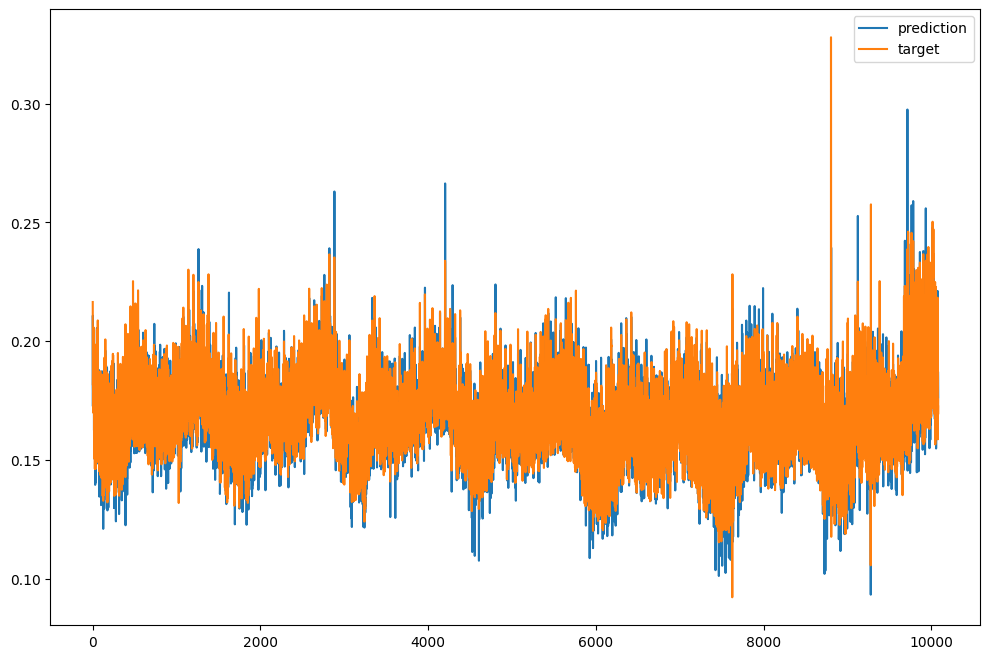

In [23]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [24]:
np.array(pred_list)

array([0.17303231, 0.21080796, 0.18320093, ..., 0.18715313, 0.18346265,
       0.17631708])

In [25]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [26]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [27]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 4.250243306159973 %
RMSE 0.009932518005371094
MAPE 4.254709929227829 %


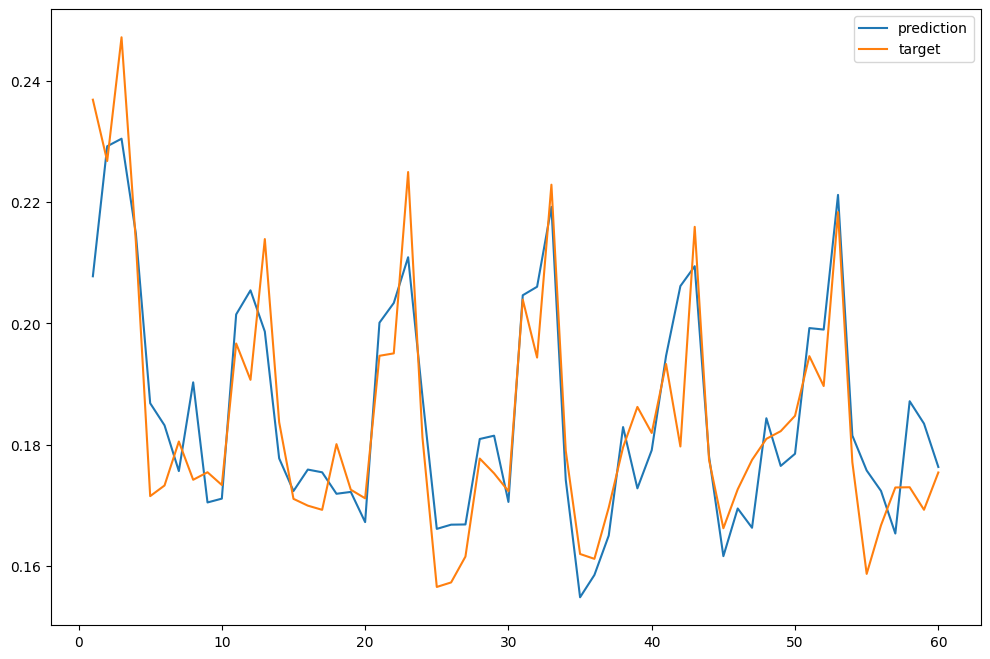

In [28]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [29]:
len(time_list)

10080

In [30]:
np.mean(time_list) 

0.2398212105745361